In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import unet
from unet import utils
from unet.datasets import circles

In [2]:
train_dataset, validation_dataset = circles.load_data(1000, nx=256, ny=256, splits=(0.8, 0.2))
train_dataset = train_dataset.repeat(10)
validation_dataset = validation_dataset.repeat(10)

In [3]:
from tensorflow.python import ipu

cfg = ipu.config.IPUConfig()
# Request 1 IPU
cfg.auto_select_ipus = 1
# # Enable asynchronous IO tiles
# cfg.io_tiles.num_io_tiles = 32
# cfg.io_tiles.place_ops_on_io_tiles = True
# Apply the configuration
cfg.configure_ipu_system()

In [4]:
with ipu.ipu_strategy.IPUStrategy(enable_dataset_iterators=False).scope():
    unet_model = unet.build_model(channels=circles.channels,
                                  num_classes=circles.classes,
                                  layer_depth=3,
                                  filters_root=16)
    unet.finalize_model(unet_model)
    
    trainer = unet.Trainer(checkpoint_callback=False)    
    trainer.fit(unet_model,
                train_dataset,
                validation_dataset,
                epochs=5,
                batch_size=2)
    
    prediction = unet_model.predict(validation_dataset.batch(batch_size=1, drop_remainder=True))

Epoch 1/5
4000/4000 [==============================] - 20s 5ms/step - loss: 0.0705 - categorical_crossentropy: 0.0705 - categorical_accuracy: 0.9777 - mean_iou: 0.6469 - dice_coefficient: 0.9630 - auc: 0.9948
Epoch 2/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0202 - categorical_crossentropy: 0.0202 - categorical_accuracy: 0.9953 - mean_iou: 0.8541 - dice_coefficient: 0.9912 - auc: 0.9988
Epoch 3/5
4000/4000 [==============================] - 14s 4ms/step - loss: 0.0157 - categorical_crossentropy: 0.0157 - categorical_accuracy: 0.9963 - mean_iou: 0.8857 - dice_coefficient: 0.9935 - auc: 0.9991
Epoch 4/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0141 - categorical_crossentropy: 0.0141 - categorical_accuracy: 0.9966 - mean_iou: 0.8992 - dice_coefficient: 0.9943 - auc: 0.9991
Epoch 5/5
4000/4000 [==============================] - 14s 3ms/step - loss: 0.0135 - categorical_crossentropy: 0.0135 - categorical_accuracy: 0.9967 - mean_iou: 0.9

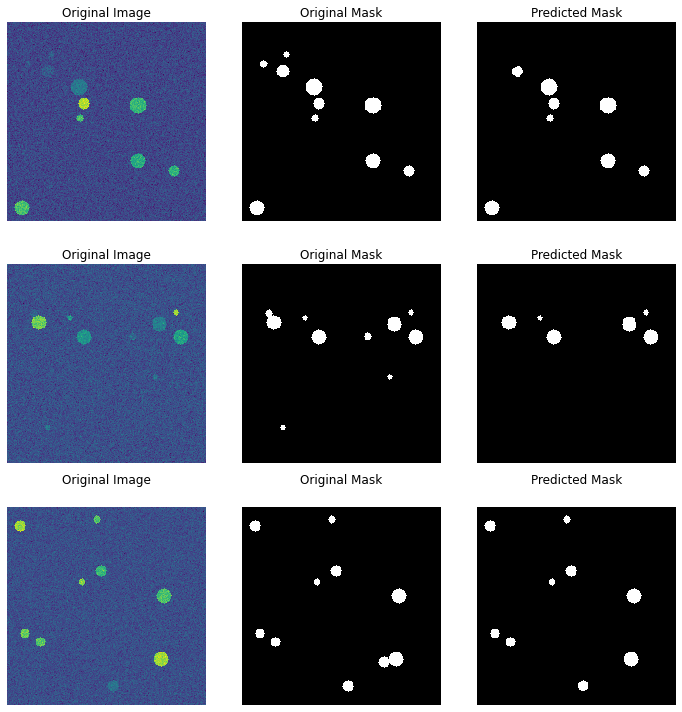

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()